In [1]:
import csv
import numpy as np
import pandas as pd
import scipy.optimize
import scipy.stats
import colorcet as cc

import bokeh.io
import bokeh.plotting
import bokeh.palettes
import bokeh.models

bokeh.io.output_notebook()

Loading BokehJS ...

#### Want to calibrate and convert the PCA fluorescence into a concentration

In [2]:
def general_hill(x, Ka, n, A, B, C):
    """
    Use a generalized hill function for the calibration curve.
    """
    
    y = B + A / (C + (Ka / x) ** n)
    
    return y

def inverse_general_hill(y, Ka, n, A, B, C):
    """
    Inverse function for deriving concentrations from fluorescence values.
    """
    
    x = Ka / ((A / (y - B) - C) ** (1/n))
    
    return x

def get_calib_data(fluor_df):
    """
    Function to extract calibration data from the general dataframe(s).
    """
    
    calib_df = fluor_df.loc[fluor_df['Strain'] == 'calibration']
    calib_df['Condition Conc. (µM)'] = calib_df['Condition Conc. (µM)'].astype(float)
    
    return calib_df

def plot_calib_point(calib_df, title=None):
    """
    Plotter for the calibration data.
    """
    
    
    fig = bokeh.plotting.figure(height=400, width=600, title=title, x_axis_label='µM PCAred', y_axis_label='Fluorescence (AU)')
    
    c = fig.circle(calib_df['Condition Conc. (µM)'], calib_df['PCAred fluorescence (AU)'], size=5, alpha=0.05, legend='Calibration measurements')
    
    fig.legend.location = 'bottom_right'
    
    return fig
    
def fit_hill(calib_df):
    """
    Function to fit the generalized Hill function to the calibration data.
    """
    
    xdata = calib_df['Condition Conc. (µM)'].values
    ydata = calib_df['PCAred fluorescence (AU)'].values
    
    popt, pcov = scipy.optimize.curve_fit(general_hill, xdata, ydata, p0 = [150, 2, 9000, 1000, 1])
    
    plot = plot_calib_point(calib_df, title='Fit of calibration model')
    
    x = np.linspace(0, 800, 100)
    fit = general_hill(x, *popt)
    
    plot.line(x, fit, color='black')
    
    bokeh.io.show(plot)
    
    return popt, pcov

def convert_fluor_to_conc(fluor_exp_df, popt):
    """
    Function to convert fluorescence measurements to concentrations.
    """
    
    fluor_exp_df['measured PCAred (µM)'] = [inverse_general_hill(f, *popt) for f in fluor_exp_df['PCAred fluorescence (AU)']]
    
    return fluor_exp_df

def fitting_pipeline(df):
    """
    Function to bring above utilities together.
    """
    
    calib_df = get_calib_data(df)
    exp_df = df.loc[df['Strain'] != 'calibration']
    
    popt, pcov = fit_hill(calib_df)
    
    exp_df = convert_fluor_to_conc(exp_df, popt)
    
    return exp_df

def linear_approximation(x_array, y_array, cutoff_time):
    """
    Function to perform a linear regression of the data up to a
    specified cutoff time. Used for generating supplementary figs 5 and 6.
    """
    
    indices = x_array < cutoff_time
    
    x = x_array[indices]
    y = y_array[indices]
    
    slope, intercept, rvalue, pvalue, stderr = scipy.stats.linregress(x, y)
    
    return slope, intercept, rvalue

def linear_range_evaluator(single_strain_single_condition_df, y_var, title=None):
    """
    Assesses the goodness of linear fit over the data for all possible cutoff times.
    Used for supplementary figs 5 and 6.
    """
    
    df = single_strain_single_condition_df.dropna()
    
    x_array = df['Time [hr]'].values
    y_array = df[y_var].values
    
    try:
        start = min(x_array)
    except:
        start = 0
    
    try:
        stop = max(x_array)
    except:
        stop = 24
    
    cutoff_times = np.linspace(start, stop, 48)
    
    r_squareds = []
    slopes = []
    ints = []
    
    for ct in cutoff_times:
        
        try:
            s, i, r = linear_approximation(x_array, y_array, ct)

            r_squareds.append(r**2)
            slopes.append(s)
            ints.append(i)
            
        except:
            r_squareds.append(None)
            slopes.append(None)
            ints.append(None)
            
    
    source = bokeh.models.ColumnDataSource(data=dict(cutoff_times=cutoff_times,
                                                     r_squareds=r_squareds,
                                                     slope_int=[f'slope: {s}\nintercept:{i}' for s, i in zip(slopes, ints)])
                                          )
        
    fig = bokeh.plotting.figure(width=200,
                                height=200,
                                x_axis_label='Cutoff time (hours)',
                                y_axis_label='R-squared',
                                title=title)
    
    c = fig.circle(x='cutoff_times', y='r_squareds', source=source)
    
    l = fig.line([start + 5, start + 5], [0, 1], color='red')
    
#     labels = bokeh.models.LabelSet(x='cutoff_times', y='r_squared', text='slope_int',
#                                    x_offset=5, y_offset=5, source=source)
    
#     fig.add_layout(labels)
    
    fig.y_range = bokeh.models.Range1d(0, 1.05)
    fig.output_backend = 'svg'
    
    return fig

def linear_assessment_plotter(df, y_var='measured PCAred (µM)'):
    """
    Function to plot R**2 against cutoff times to determine a linear range to estimate
    initial rates for all the strains and conditions. Used for supplementary figs 5 and 6.
    """
    
    grouped = df.groupby(['Strain', 'Condition'])
    
    plots = []
    
    for g in grouped:
        strain = g[0][0]
        condition = g[0][1]
        mini_df = g[1]
        
        if condition == 'PCA, NO2':
            mini_df = mini_df.loc[mini_df['Time [hr]'] > 1.5]
        
        title = f'{strain} with {condition} linearity'
        
#         print(strain, condition)
        p = linear_range_evaluator(mini_df, y_var, title)
        
        plots.append(p)
        
    return plots

def get_initial_redox_rates(single_strain_single_condition_df, y='measured PCAred (µM)', verbose=True):
    
    mdf = single_strain_single_condition_df
    
    condition = mdf['Condition'].unique()
    strain = mdf['Strain'].unique()
    
    mdf = mdf.dropna()
    
    try:
        first_data_time = min(mdf['Time [hr]'].values)
    except:
        first_data_time = 0
    
    if condition != 'PCA, NO2':

        lin_reg_df = mdf.loc[mdf['Time [hr]'] <= 5 + first_data_time]
        
    else:
#         first_data_time = 0
        lin_reg_df = mdf.loc[(mdf['Time [hr]'] > 1.5) & (mdf['Time [hr]'] <= 5 + first_data_time)]
        
    
    if len(lin_reg_df) == 0:
        if verbose == True:
            print(f"""
            {strain}
            ------
            {condition}: no detectable redox
            """)
        
        return 0, 0, 0
        
    else:    
        slope, inter, r, p, e = scipy.stats.linregress(lin_reg_df['Time [hr]'].values,
                                               lin_reg_df[y].values)
        
        if verbose == True:
            print(f"""
            {strain}
            ------
            {condition}: init redox rate {slope:.2f} +/- {e*1.96:.2f} µM/hr
            """)
        
        return slope, inter, e
        

def plotter(df, 
            plot_grouping, 
            color_grouping, 
            y='measured PCAred (µM)', 
            y_axis_label='Reduced PCA (µM)', 
            x_axis_label='Time (hrs)'):
    
    """
    Function to plot the data for paper figures.
    
    plot_grouping and color_grouping are either "Condition" or "Strain"
    """
    
    plot_grouped = df.groupby(plot_grouping)
    
    plots = []
    
    for grp in plot_grouped:
        
        title = f"{plot_grouping}: {grp[0]}"
        
        fig = bokeh.plotting.figure(
                width=600,
                height=300,
                title=title,
                y_axis_label=y_axis_label,
                x_axis_label=x_axis_label
            )
        
        mini_df = grp[1]
        
        color_grouped = mini_df.groupby(color_grouping)
        
        palette = list(bokeh.palettes.Colorblind6)
        palette[0] = 'grey'
        
        legend_items = []
        
        for i, g in enumerate(color_grouped):
            
            label = g[0]
            
            mdf = g[1]
            
            try:
                wells = mdf['Well'].unique()
            
            except:
                wells = []
            
            if len(wells) > 1: # Need to account for replicates
                
                measurement_arrays = []
                cs = []
                for w in wells:
                    time = mdf.loc[mdf['Well'] == w]['Time [hr]'].values
                    measurement = mdf.loc[mdf['Well'] == w][y].values
                    
                    measurement_arrays.append(measurement)
                    
                    c = fig.circle(time, measurement, color = palette[i], alpha=0.2, size=2)
                    cs.append(c)
                    
                mean = sum(measurement_arrays) / len(measurement_arrays)
                
                l = fig.line(time, mean, color = palette[i], alpha=1, line_width=3)
                
                legend_items.append((label, [l, *cs]))
#                 print(legend_items)
                
            else:
                time = mdf['Time [hr]'].values
                measurement = mdf[y].values
                
                c = fig.circle(time, measurement, color = palette[i], alpha=0.7)
                
                legend_items.append((label, [c]))
                
            if plot_grouping == 'Strain' and y == 'measured PCAred (µM)':
                
                slope, inter, e = get_initial_redox_rates(mdf)
                
                if slope != 0:
                    
                    lin_x = np.linspace(0,24,5)
                    lin_y = slope * lin_x + inter
                    reg_l = fig.line(lin_x, lin_y, color = palette[i], line_dash='dashed', line_width=2, alpha=1)
        
        if y == 'measured PCAred (µM)':
            fig.y_range = bokeh.models.Range1d(-5, 205)
            
        elif y == 'OD600' or y == 'Mean OD600':
            fig.y_range = bokeh.models.Range1d(0, 0.3)
        
        legend = bokeh.models.Legend(items=legend_items)
        legend.click_policy = "hide"
        
        fig.add_layout(legend, 'right')
        
        fig.legend.label_text_font_style = "italic"
        fig.legend.label_text_font_size = '12pt'
        fig.title.text_font_size = "14pt"
        
        fig.yaxis.axis_label_text_font_size = '12pt'
        fig.xaxis.axis_label_text_font_size = '12pt'
        
        fig.yaxis.major_label_text_font_size = '10pt'
        fig.xaxis.major_label_text_font_size = '10pt'
        
        fig.output_backend = 'svg'
        
        plots.append(fig)
        
        for p in plots[1:]:
            p.x_range = plots[0].x_range
            p.y_range = plots[0].y_range
            
    return plots
    
    

## Notebook to generate figures for _C. portucalensis_ MBL Observation paper for mBio

### Load the data

In [3]:
reduction_df = pd.read_csv('./data/reduction_assay_dataframe.csv')
oxidation_df = pd.read_csv('./data/oxidation_assay_dataframe.csv')

### Calibrate the fluorescence measurements to concentrations of reduced PCA (PCAred)

In [4]:
oxidation_df = fitting_pipeline(oxidation_df)
oxidation_df

/Users/lmt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/lmt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: divide by zero encountered in true_divide
  
/Users/lmt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in power
  


/Users/lmt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
/Users/lmt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:69: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Time [hr] Well  PCAred fluorescence (AU)                Strain  \
3468       0.061   B1                      5796  C. portucalensis MBL   
3469       0.144   B1                      5815  C. portucalensis MBL   
3470       0.228   B1                      5835  C. portucalensis MBL   
3471       0.311   B1                      5802  C. portucalensis MBL   
3472       0.394   B1                      5806  C. portucalensis MBL   
...          ...  ...                       ...                   ...   
24271     23.728  G12                      5989               Abiotic   
24272     23.811  G12                      5975               Abiotic   
24273     23.894  G12                      5986               Abiotic   
24274     23.978  G12                      5977               Abiotic   
24275     24.061  G12                      5974               Abiotic   

             Medium Condition Condition Conc. (µM)  OD600  \
3468   basal medium       PCA                  200  0.096   
3469   basal medium       PCA                  200  0.098   
3470   basal medium       PCA                  200  0.098   
3471   basal medium       PCA                  200  0.100   
3472   basal medium       PCA                  200  0.101   
...             ...       ...                  ...    ...   
24271  basal medium  PCA, Fum           200, 10000  0.076   
24272  basal medium  PCA, Fum           200, 10000  0.076   
24273  basal medium  PCA, Fum           200, 10000  0.076   
24274  basal medium  PCA, Fum           200, 10000  0.076   
24275  basal medium  PCA, Fum           200, 10000  0.076   

       measured PCAred (µM)  
3468             168.579375  
3469             169.728620  
3470             170.947811  
3471             168.941355  
3472             169.183156  
...                     ...  
24271            180.675627  
24272            179.765455  
24273            180.480140  
24274            179.895152  
24275            179.700646  

[20808 rows x 9 columns]

In [5]:
reduction_df = fitting_pipeline(reduction_df)
reduction_df

/Users/lmt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/lmt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: divide by zero encountered in true_divide
  
/Users/lmt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in power
  


/Users/lmt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
/Users/lmt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:69: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Time [hr] Well  PCAred fluorescence (AU)                Strain  \
3468       0.061   B1                       753  C. portucalensis MBL   
3469       0.144   B1                       741  C. portucalensis MBL   
3470       0.228   B1                       742  C. portucalensis MBL   
3471       0.311   B1                       760  C. portucalensis MBL   
3472       0.394   B1                       773  C. portucalensis MBL   
...          ...  ...                       ...                   ...   
24271     23.728  G12                       681               Abiotic   
24272     23.811  G12                       688               Abiotic   
24273     23.894  G12                       689               Abiotic   
24274     23.978  G12                       693               Abiotic   
24275     24.061  G12                       689               Abiotic   

             Medium Condition Condition Conc. (µM)  OD600  \
3468   basal medium       PCA                  200  0.102   
3469   basal medium       PCA                  200  0.104   
3470   basal medium       PCA                  200  0.106   
3471   basal medium       PCA                  200  0.106   
3472   basal medium       PCA                  200  0.107   
...             ...       ...                  ...    ...   
24271  basal medium  PCA, Fum           200, 10000  0.075   
24272  basal medium  PCA, Fum           200, 10000  0.075   
24273  basal medium  PCA, Fum           200, 10000  0.076   
24274  basal medium  PCA, Fum           200, 10000  0.076   
24275  basal medium  PCA, Fum           200, 10000  0.076   

       measured PCAred (µM)  
3468                    NaN  
3469                    NaN  
3470                    NaN  
3471                    NaN  
3472                    NaN  
...                     ...  
24271                   NaN  
24272                   NaN  
24273                   NaN  
24274                   NaN  
24275                   NaN  

[20808 rows x 9 columns]

#### Note: In the calibration plots above, you can see that the fluorescence measurements at a given concentration tended to increase over time (the blue smear at higher concentrations). Since this happened abiotically, it's some sort of artifact, but I kept it and its implications in for my analysis.

### Assess linear fits for initial redox rates

#### For oxidation assays

In [6]:
ox_linearity_plots = linear_assessment_plotter(oxidation_df)

In [7]:
bokeh.io.show(bokeh.layouts.gridplot(ox_linearity_plots, ncols=4))

In [8]:
# bokeh.io.export_svgs(ox_linearity_plots, filename='./plots/linearity/oxidation_Rsquared_vs_cutoff.svg')

#### For reduction assays

In [9]:
red_linearity_plots = linear_assessment_plotter(reduction_df)
bokeh.io.show(bokeh.layouts.gridplot(red_linearity_plots, ncols=4))

/Users/lmt/miniconda3/lib/python3.7/site-packages/scipy/stats/_stats_mstats_common.py:130: RuntimeWarning: invalid value encountered in double_scalars
  slope = r_num / ssxm
/Users/lmt/miniconda3/lib/python3.7/site-packages/scipy/stats/_stats_mstats_common.py:140: RuntimeWarning: invalid value encountered in sqrt
  t = r * np.sqrt(df / ((1.0 - r + TINY)*(1.0 + r + TINY)))
/Users/lmt/miniconda3/lib/python3.7/site-packages/scipy/stats/_stats_mstats_common.py:142: RuntimeWarning: invalid value encountered in double_scalars
  sterrest = np.sqrt((1 - r**2) * ssym / ssxm / df)


In [10]:
# bokeh.io.export_svgs(red_linearity_plots, filename='./plots/linearity/reduction_Rsquared_vs_cutoff.svg')

### Generate oxidation assay plots by strain and condition (when evaluating by strain, output the initial linear fits)

In [11]:
oxidation_plots_by_condition = plotter(oxidation_df, 'Condition', 'Strain')

In [14]:
oxidation_plots_by_strain = plotter(oxidation_df, 'Strain', 'Condition')


            ['Abiotic']
            ------
            ['PCA']: init redox rate 1.36 +/- 0.32 µM/hr
            

            ['Abiotic']
            ------
            ['PCA, Fum']: init redox rate 1.41 +/- 0.63 µM/hr
            

            ['Abiotic']
            ------
            ['PCA, NO2']: init redox rate -1.48 +/- 0.29 µM/hr
            

            ['Abiotic']
            ------
            ['PCA, NO3']: init redox rate 1.26 +/- 0.45 µM/hr
            

            ['C. portucalensis MBL']
            ------
            ['PCA']: init redox rate 1.45 +/- 0.15 µM/hr
            

            ['C. portucalensis MBL']
            ------
            ['PCA, Fum']: init redox rate -6.49 +/- 0.50 µM/hr
            

            ['C. portucalensis MBL']
            ------
            ['PCA, NO2']: init redox rate -0.41 +/- 0.39 µM/hr
            

            ['C. portucalensis MBL']
            ------
            ['PCA, NO3']: init redox rate -25.23 +/- 0.84 µM/hr
            



### Generate reduction assay plots by strain and condition (when evaluating by strain, output the initial linear fits)

In [15]:
reduction_plots_by_condition = plotter(reduction_df, 'Condition', 'Strain')

In [16]:
reduction_plots_by_strain = plotter(reduction_df, 'Strain', 'Condition')


            ['Abiotic']
            ------
            ['PCA']: no detectable redox
            

            ['Abiotic']
            ------
            ['PCA, Fum']: no detectable redox
            

            ['Abiotic']
            ------
            ['PCA, NO2']: no detectable redox
            

            ['Abiotic']
            ------
            ['PCA, NO3']: no detectable redox
            

            ['C. portucalensis MBL']
            ------
            ['PCA']: init redox rate 5.30 +/- 0.05 µM/hr
            

            ['C. portucalensis MBL']
            ------
            ['PCA, Fum']: init redox rate 2.92 +/- 0.11 µM/hr
            

            ['C. portucalensis MBL']
            ------
            ['PCA, NO2']: init redox rate 4.05 +/- 0.07 µM/hr
            

            ['C. portucalensis MBL']
            ------
            ['PCA, NO3']: no detectable redox
            

            ['E. coli MG1655']
            ------
            ['PCA']: init redox rat

#### Check out some plot examples

In [17]:
bokeh.io.show(oxidation_plots_by_condition[2])

In [18]:
bokeh.io.show(oxidation_plots_by_strain[3])

In [19]:
bokeh.io.show(reduction_plots_by_condition[0])

In [30]:
bokeh.io.show(reduction_plots_by_strain[1])

In [29]:
# bokeh.io.export_svgs(oxidation_plots_by_condition, filename='./plots/oxidation/oxidation_plots_by_condition.svg')
# bokeh.io.export_svgs(oxidation_plots_by_strain, filename='./plots/oxidation/oxidation_plots_by_strain.svg')

# bokeh.io.export_svgs(reduction_plots_by_condition, filename='./plots/reduction/reduction_plots_by_condition.svg')
# bokeh.io.export_svgs(reduction_plots_by_strain, filename='./plots/reduction/reduction_plots_by_strain.svg')

#### Generate color maps for fig 1 table

<img src='data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAEAAAABACAYAAACqaXHeAAAABHNCSVQICAgIfAhkiAAAAAlwSFlz
AAAB+wAAAfsBxc2miwAAABl0RVh0U29mdHdhcmUAd3d3Lmlua3NjYXBlLm9yZ5vuPBoAAA6zSURB
VHic7ZtpeFRVmsf/5966taWqUlUJ2UioBBJiIBAwCZtog9IOgjqACsogKtqirT2ttt069nQ/zDzt
tI4+CrJIREFaFgWhBXpUNhHZQoKBkIUASchWla1S+3ar7r1nPkDaCAnZKoQP/D7mnPOe9/xy76n3
nFSAW9ziFoPFNED2LLK5wcyBDObkb8ZkxuaoSYlI6ZcOKq1eWFdedqNzGHQBk9RMEwFAASkk0Xw3
ETacDNi2vtvc7L0ROdw0AjoSotQVkKSvHQz/wRO1lScGModBFbDMaNRN1A4tUBCS3lk7BWhQkgpD
lG4852/+7DWr1R3uHAZVQDsbh6ZPN7CyxUrCzJMRouusj0ipRwD2uKm0Zn5d2dFwzX1TCGhnmdGo
G62Nna+isiUqhkzuKrkQaJlPEv5mFl2fvGg2t/VnzkEV8F5ioioOEWkLG86fvbpthynjdhXYZziQ
x1hC9J2NFyi8vCTt91Fh04KGip0AaG9zuCk2wQCVyoNU3Hjezee9bq92duzzTmxsRJoy+jEZZZYo
GTKJ6SJngdJqAfRzpze0+jHreUtPc7gpBLQnIYK6BYp/uGhw9YK688eu7v95ysgshcg9qSLMo3JC
4jqLKQFBgdKDPoQ+Pltb8dUyQLpeDjeVgI6EgLIQFT5tEl3rn2losHVsexbZ3EyT9wE1uGdkIPcy
BGxn8QUq1QrA5nqW5i2tLqvrrM9NK6AdkVIvL9E9bZL/oyfMVd/jqvc8LylzRBKDJSzIExwhQzuL
QYGQj4rHfFTc8mUdu3E7yoLtbTe9gI4EqVgVkug2i5+uXGo919ixbRog+3fTbQ8qJe4ZOYNfMoTI
OoshUNosgO60AisX15aeI2PSIp5KiFLI9ubb1vV3Qb2ltwLakUCDAkWX7/nHKRmmGIl9VgYsUhJm
2NXjKYADtM1ygne9QQDIXlk49FBstMKx66D1v4+XuQr7vqTe0VcBHQlRWiOCbmmSYe2SqtL6q5rJ
zsTb7lKx3FKOYC4DoqyS/B5bvLPxvD9Qtf6saxYLQGJErmDOdOMr/zo96km1nElr8bmPOBwI9COv
HnFPRIwmkSOv9kcAS4heRsidOkpeWBgZM+UBrTFAXNYL5Vf2ii9c1trNzpYdaoVil3WIc+wdk+gQ
noie3ecCcxt9ITcLAPWt/laGEO/9U6PmzZkenTtsSMQ8uYywJVW+grCstAvCIaAdArAsIWkRDDs/
KzLm2YcjY1Lv0UdW73HabE9n6V66cxSzfEmuJssTpKGVp+0vHq73FwL46eOjpMpbRAnNmJFrGJNu
Ukf9Yrz+3rghiumCKNXXWPhLYcjxGsIpoCMsIRoFITkW8AuyM8jC1+/QLx4bozCEJIq38+1rtpR6
V/yzb8eBlRb3fo5l783N0CWolAzJHaVNzkrTzlEp2bQ2q3TC5gn6wpnoQAmwSiGh2GitnTmVMc5O
UyfKWUKCIsU7+fZDKwqdT6DDpvkzAX4/+AMFjk0tDp5GRXLpQ2MUmhgDp5gxQT8+Y7hyPsMi8uxF
71H0oebujHALECjFKaW9Lm68n18wXp2kVzIcABytD5iXFzg+WVXkegpAsOOYziqo0OkK76GyquC3
ltZAzMhhqlSNmmWTE5T6e3IN05ITFLM4GdN0vtZ3ob8Jh1NAKXFbm5PtLU/eqTSlGjkNAJjdgn/N
aedXa0tdi7+t9G0FIF49rtMSEgAs1kDLkTPO7ebm4IUWeyh1bKomXqlgMG6kJmHcSM0clYLJ8XtR
1GTnbV3F6I5wCGikAb402npp1h1s7LQUZZSMIfALFOuL3UUrfnS8+rez7v9qcold5tilgHbO1fjK
9ubb17u9oshxzMiUBKXWqJNxd+fqb0tLVs4lILFnK71H0Ind7uiPgACVcFJlrb0tV6DzxqqTIhUM
CwDf1/rrVhTa33/3pGPxJYdQ2l2cbgVcQSosdx8uqnDtbGjh9SlDVSMNWhlnilfqZk42Th2ZpLpf
xrHec5e815zrr0dfBZSwzkZfqsv+1FS1KUknUwPARVvItfKUY+cn57yP7qv07UE3p8B2uhUwLk09
e0SCOrK+hbdYHYLjRIl71wWzv9jpEoeOHhGRrJAzyEyNiJuUqX0g2sBN5kGK6y2Blp5M3lsB9Qh4
y2Ja6x6+i0ucmKgwMATwhSjdUu49tKrQ/pvN5d53ml2CGwCmJipmKjgmyuaXzNeL2a0AkQ01Th5j
2DktO3Jyk8f9vcOBQHV94OK+fPumJmvQHxJoWkaKWq9Vs+yUsbq0zGT1I4RgeH2b5wef7+c7bl8F
eKgoHVVZa8ZPEORzR6sT1BzDUAD/d9F78e2Tzv99v8D+fLVTqAKAsbGamKey1Mt9Ann4eH3gTXTz
idWtAJ8PQWOk7NzSeQn/OTHDuEikVF1R4z8BQCy+6D1aWRfY0tTGG2OM8rRoPaeIj5ZHzJxszElN
VM8K8JS5WOfv8mzRnQAKoEhmt8gyPM4lU9SmBK1MCQBnW4KONT86v1hZ1PbwSXPw4JWussVjtH9Y
NCoiL9UoH/6PSu8jFrfY2t36erQHXLIEakMi1SydmzB31h3GGXFDFNPaK8Rme9B79Ixrd0WN+1ij
NRQ/doRmuFLBkHSTOm5GruG+pFjFdAmorG4IXH1Qua6ASniclfFtDYt+oUjKipPrCQB7QBQ2lrgP
fFzm+9XWUtcqJ3/5vDLDpJ79XHZk3u8nGZ42qlj1+ydtbxysCezrydp6ugmipNJ7WBPB5tydY0jP
HaVNzs3QzeE4ZpTbI+ZbnSFPbVOw9vsfnVvqWnirPyCNGD08IlqtYkh2hjZ5dErEQzoNm+6ykyOt
Lt5/PQEuSRRKo22VkydK+vvS1XEKlhCJAnsqvcVvH7f/ZU2R67eXbMEGAMiIV5oWZWiWvz5Fv2xG
sjqNJQRvn3Rs2lji/lNP19VjAQDgD7FHhujZB9OGqYxRkZxixgRDVlqS6uEOFaJUVu0rPFzctrnF
JqijImVp8dEKVWyUXDk92zAuMZ6bFwpBU1HrOw6AdhQgUooChb0+ItMbWJitSo5Ws3IAOGEOtL53
0vHZih9sC4vtofZ7Qu6523V/fmGcds1TY3V36pUsBwAbSlxnVh2xLfAD/IAIMDf7XYIkNmXfpp2l
18rkAJAy9HKFaIr/qULkeQQKy9zf1JgDB2uaeFNGijo5QsUyacNUUTOnGO42xSnv4oOwpDi1zYkc
efUc3I5Gk6PhyTuVKaOGyLUAYPGIoY9Pu/atL/L92+4q9wbflRJ2Trpm/jPjdBtfnqB/dIThcl8A
KG7hbRuKnb8qsQsVvVlTrwQAQMUlf3kwJI24Z4JhPMtcfng5GcH49GsrxJpGvvHIaeem2ma+KSjQ
lIwUdYyCY8j4dE1KzijNnIP2llF2wcXNnsoapw9XxsgYAl6k+KzUXbi2yP3KR2ecf6z3BFsBICdW
nvnIaG3eHybqX7vbpEqUMT+9OL4Qpe8VON7dXuFd39v19FoAABRVePbGGuXTszO0P7tu6lghUonE
llRdrhArLvmKdh9u29jcFiRRkfLUxBiFNiqSU9icoZQHo5mYBI1MBgBH6wMNb+U7Pnw337H4gi1Y
ciWs+uks3Z9fztUvfzxTm9Ne8XXkvQLHNytOOZeiD4e0PgkAIAYCYknKUNUDSXEKzdWNpnil7r4p
xqkjTarZMtk/K8TQ6Qve78qqvXurGwIJqcOUKfUWHsm8KGvxSP68YudXq4pcj39X49uOK2X142O0
Tz5/u/7TVybqH0rSya6ZBwD21/gubbrgWdDgEOx9W
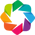

In [2]:
import holoviews as hv
from holoviews import opts
hv.extension('bokeh')

In [23]:
all_ox_strain_conditions = oxidation_df.groupby(['Strain', 'Condition'])
all_red_strain_conditions = reduction_df.groupby(['Strain', 'Condition'])

assays = []
strains = []
conds = []
rates = []

for i, grp in enumerate(all_ox_strain_conditions):
    
    strain = grp[0][0]
    cond = grp[0][1]
    df = grp[1]
    
    slope, inter, er = get_initial_redox_rates(df, verbose=False)
    
    assays.append('ox')
    strains.append(strain)
    conds.append(cond)
    rates.append(slope)
    

for i, grp in enumerate(all_red_strain_conditions):
    
    strain = grp[0][0]
    cond = grp[0][1]
    df = grp[1]
    
    slope, inter, er = get_initial_redox_rates(df, verbose=False)
    assays.append('red')
    strains.append(strain)
    conds.append(cond)
    rates.append(slope)
    
init_rate_df = pd.DataFrame.from_dict({'assay': assays,
                                       'strain': strains,
                                       'condition': conds,
                                       'initial redox rate (µM/hr)': rates})

init_rate_df

assay                    strain condition  initial redox rate (µM/hr)
0     ox                   Abiotic       PCA                    1.360447
1     ox                   Abiotic  PCA, Fum                    1.413900
2     ox                   Abiotic  PCA, NO2                   -1.475485
3     ox                   Abiotic  PCA, NO3                    1.258646
4     ox      C. portucalensis MBL       PCA                    1.451656
5     ox      C. portucalensis MBL  PCA, Fum                   -6.487341
6     ox      C. portucalensis MBL  PCA, NO2                   -0.412340
7     ox      C. portucalensis MBL  PCA, NO3                  -25.227755
8     ox            E. coli MG1655       PCA                    1.873454
9     ox            E. coli MG1655  PCA, Fum                    1.434195
10    ox            E. coli MG1655  PCA, NO2                   -0.495635
11    ox            E. coli MG1655  PCA, NO3                   -6.696782
12    ox  P. aeruginosa PA14 ∆phz*       PCA                    0.932438
13    ox  P. aeruginosa PA14 ∆phz*  PCA, Fum                    0.800375
14    ox  P. aeruginosa PA14 ∆phz*  PCA, NO2                   -1.837080
15    ox  P. aeruginosa PA14 ∆phz*  PCA, NO3                  -10.089749
16    ox    P. aureofaciens phzB::       PCA                    1.020174
17    ox    P. aureofaciens phzB::  PCA, Fum                    1.413620
18    ox    P. aureofaciens phzB::  PCA, NO2                   -2.745896
19    ox    P. aureofaciens phzB::  PCA, NO3                    1.494975
20    ox    P. chlororaphis phzB::       PCA                    1.523465
21    ox    P. chlororaphis phzB::  PCA, Fum                    1.790251
22    ox    P. chlororaphis phzB::  PCA, NO2                   -3.097902
23    ox    P. chlororaphis phzB::  PCA, NO3                    1.329456
24   red                   Abiotic       PCA                    0.000000
25   red                   Abiotic  PCA, Fum                    0.000000
26   red                   Abiotic  PCA, NO2                    0.000000
27   red                   Abiotic  PCA, NO3                    0.000000
28   red      C. portucalensis MBL       PCA                    5.303304
29   red      C. portucalensis MBL  PCA, Fum                    2.918993
30   red      C. portucalensis MBL  PCA, NO2                    4.047701
31   red      C. portucalensis MBL  PCA, NO3                    0.000000
32   red            E. coli MG1655       PCA                    3.419151
33   red            E. coli MG1655  PCA, Fum                    2.697420
34   red            E. coli MG1655  PCA, NO2                    2.778927
35   red            E. coli MG1655  PCA, NO3                    0.802378
36   red  P. aeruginosa PA14 ∆phz*       PCA                    1.244470
37   red  P. aeruginosa PA14 ∆phz*  PCA, Fum                    1.442919
38   red  P. aeruginosa PA14 ∆phz*  PCA, NO2                    0.000000
39   red  P. aeruginosa PA14 ∆phz*  PCA, NO3                    0.000000
40   red    P. aureofaciens phzB::       PCA                    1.973649
41   red    P. aureofaciens phzB::  PCA, Fum                    1.630229
42   red    P. aureofaciens phzB::  PCA, NO2                    0.000000
43   red    P. aureofaciens phzB::  PCA, NO3                    1.908217
44   red    P. chlororaphis phzB::       PCA                    1.019706
45   red    P. chlororaphis phzB::  PCA, Fum                    1.222468
46   red    P. chlororaphis phzB::  PCA, NO2                    0.000000
47   red    P. chlororaphis phzB::  PCA, NO3                    0.708392

In [24]:
ox_cmap = cc.coolwarm
red_cmap = cc.fire[::-1]


In [25]:
ox_hm = hv.HeatMap(init_rate_df.loc[init_rate_df['assay'] == 'ox'], kdims=['condition', 'strain'], vdims='initial redox rate (µM/hr)')
ox_hm.opts(opts.HeatMap(tools=['hover'], colorbar=True, width=325, toolbar='above', clim=(-25, 2), cmap=ox_cmap[:-110], xrotation=45))
ox_hm.output_backend = 'svg'

In [26]:
ox_hm

:HeatMap   [condition,strain]   (initial redox rate (µM/hr))

In [27]:
ox_hm = hv.HeatMap(init_rate_df.loc[init_rate_df['assay'] == 'red'], kdims=['condition', 'strain'], vdims='initial redox rate (µM/hr)')
ox_hm.opts(opts.HeatMap(tools=['hover'], colorbar=True, width=325, toolbar='above', clim=(0, 6), cmap=red_cmap, xrotation=45))

:HeatMap   [condition,strain]   (initial redox rate (µM/hr))

### Generate OD plots for oxidation assays by strain and checkout and example

In [20]:
oxidation_OD_by_strain = plotter(oxidation_df, 'Strain', 'Condition', y='OD600', y_axis_label='OD600')

In [21]:
bokeh.io.show(oxidation_OD_by_strain[5])

In [22]:
# bokeh.io.export_svgs(oxidation_OD_by_strain, filename='./plots/OD600/oxidation_OD600_by_strain.svg')

### Generate OD plots for reduction assays by strain and checkout and example

In [23]:
reduction_OD_by_strain = plotter(reduction_df, 'Strain', 'Condition', y='OD600', y_axis_label='OD600')

In [24]:
bokeh.io.show(reduction_OD_by_strain[2])

In [25]:
# bokeh.io.export_svgs(reduction_OD_by_strain, filename='./plots/OD600/reduction_OD600_by_strain.svg')

#### Load data for ion chromatography

In [26]:
ic_df = pd.read_csv('./data/ion_chromatography_tidy.csv')
ic_df.head()

Sample ID timepoint  Nitrite (mM)  Nitrate (mM)  Acetate (mM) row  column  \
0        B1        T0        0.0777       10.3053        0.0552   B       1   
1        C1        T0        0.0455       10.5099        0.0328   C       1   
2        D1        T0        0.0695       10.8882        0.0187   D       1   
3        B4        T0        0.0775       10.3049        0.0543   B       4   
4        C4        T0        0.0844       10.6758        0.0196   C       4   

   ace           pca                strain  Time (hours)  
0    0      0 µM PCA  C. portucalensis MBL           0.0  
1    0      0 µM PCA  C. portucalensis MBL           0.0  
2    0      0 µM PCA  C. portucalensis MBL           0.0  
3    0  200 µM PCAox  C. portucalensis MBL           0.0  
4    0  200 µM PCAox  C. portucalensis MBL           0.0

In [27]:
abio_ic_df = ic_df.loc[ic_df['row'] == 'E']
bio_ic_df = ic_df.loc[ic_df['row'] != 'E']

In [28]:
bio_ic_df

Sample ID timepoint  Nitrite (mM)  Nitrate (mM)  Acetate (mM) row  column  \
0          B1        T0        0.0777       10.3053        0.0552   B       1   
1          C1        T0        0.0455       10.5099        0.0328   C       1   
2          D1        T0        0.0695       10.8882        0.0187   D       1   
3          B4        T0        0.0775       10.3049        0.0543   B       4   
4          C4        T0        0.0844       10.6758        0.0196   C       4   
..        ...       ...           ...           ...           ...  ..     ...   
103        C6        T3       11.4206        0.0078       46.9181   C       6   
104        D6        T3       11.2461        0.0145       47.5036   D       6   
105        B9        T3       11.2677        0.0154       47.0770   B       9   
106        C9        T3       11.4955        0.0086       48.1258   C       9   
107        D9        T3       11.2502        0.0096       47.3701   D       9   

     ace            pca                strain  Time (hours)  
0      0       0 µM PCA  C. portucalensis MBL           0.0  
1      0       0 µM PCA  C. portucalensis MBL           0.0  
2      0       0 µM PCA  C. portucalensis MBL           0.0  
3      0   200 µM PCAox  C. portucalensis MBL           0.0  
4      0   200 µM PCAox  C. portucalensis MBL           0.0  
..   ...            ...                   ...           ...  
103   50   200 µM PCAox  C. portucalensis MBL          53.0  
104   50   200 µM PCAox  C. portucalensis MBL          53.0  
105   50  200 µM PCAred  C. portucalensis MBL          53.0  
106   50  200 µM PCAred  C. portucalensis MBL          53.0  
107   50  200 µM PCAred  C. portucalensis MBL          53.0  

[108 rows x 11 columns]

#### Get 95% confidence intervals

In [29]:
grouped = bio_ic_df.groupby(['Time (hours)', 'strain', 'pca', 'ace'])

times = []
strains = []
pcas = []
aces = []

no3_means = []
no2_means = []
ace_means = []

no3_standard_errors = []
no2_standard_errors = []
ace_standard_errors = []

for g in grouped:
    
    times.append(g[0][0])
    strains.append(g[0][1])
    pcas.append(g[0][2])
    aces.append(g[0][3])
    
    no3_means.append(np.mean(g[1]['Nitrate (mM)']))
    no3_standard_errors.append(np.std(g[1]['Nitrate (mM)'])/np.sqrt(3))
    
    no2_means.append(np.mean(g[1]['Nitrite (mM)']))
    no2_standard_errors.append(np.std(g[1]['Nitrite (mM)'])/np.sqrt(3))
    
    ace_means.append(np.mean(g[1]['Acetate (mM)']))
    ace_standard_errors.append(np.std(g[1]['Acetate (mM)'])/np.sqrt(3))

no3_stat_df = pd.DataFrame.from_dict({'strain': strains,
                                      'Time (hours)': times,
                                      'pca': pcas,
                                      'ace': aces,
                                      'mid': no3_means,
                                      'se': no3_standard_errors,})

no2_stat_df = pd.DataFrame.from_dict({'strain': strains,
                                      'Time (hours)': times,
                                      'pca': pcas,
                                      'ace': aces,
                                      'mid': no2_means,
                                      'se': no2_standard_errors,})

ace_stat_df = pd.DataFrame.from_dict({'strain': strains,
                                      'Time (hours)': times,
                                      'pca': pcas,
                                      'ace': aces,
                                      'mid': ace_means,
                                      'se': ace_standard_errors,})

no3_stat_df['low'] = no3_stat_df['mid'] - 1.96 * no3_stat_df['se']
no3_stat_df['high'] = no3_stat_df['mid'] + 1.96 * no3_stat_df['se']

no2_stat_df['low'] = no2_stat_df['mid'] - 1.96 * no2_stat_df['se']
no2_stat_df['high'] = no2_stat_df['mid'] + 1.96 * no2_stat_df['se']

ace_stat_df['low'] = ace_stat_df['mid'] - 1.96 * ace_stat_df['se']
ace_stat_df['high'] = ace_stat_df['mid'] + 1.96 * ace_stat_df['se']

In [30]:
no3_stat_df

strain  Time (hours)            pca  ace        mid  \
0   C. portucalensis MBL           0.0       0 µM PCA    0  10.567800   
1   C. portucalensis MBL           0.0       0 µM PCA   10  10.227733   
2   C. portucalensis MBL           0.0       0 µM PCA   50  10.456767   
3   C. portucalensis MBL           0.0   200 µM PCAox    0  10.488133   
4   C. portucalensis MBL           0.0   200 µM PCAox   10  10.273867   
5   C. portucalensis MBL           0.0   200 µM PCAox   50  10.371233   
6   C. portucalensis MBL           0.0  200 µM PCAred    0  10.385700   
7   C. portucalensis MBL           0.0  200 µM PCAred   10  10.322467   
8   C. portucalensis MBL           0.0  200 µM PCAred   50  10.392467   
9   C. portucalensis MBL           8.0       0 µM PCA    0  10.541967   
10  C. portucalensis MBL           8.0       0 µM PCA   10   7.967133   
11  C. portucalensis MBL           8.0       0 µM PCA   50   8.086400   
12  C. portucalensis MBL           8.0   200 µM PCAox    0  10.208233   
13  C. portucalensis MBL           8.0   200 µM PCAox   10   7.935067   
14  C. portucalensis MBL           8.0   200 µM PCAox   50   7.960967   
15  C. portucalensis MBL           8.0  200 µM PCAred    0   9.340000   
16  C. portucalensis MBL           8.0  200 µM PCAred   10   7.779300   
17  C. portucalensis MBL           8.0  200 µM PCAred   50   7.681633   
18  C. portucalensis MBL          32.5       0 µM PCA    0  10.265633   
19  C. portucalensis MBL          32.5       0 µM PCA   10   2.765767   
20  C. portucalensis MBL          32.5       0 µM PCA   50   3.915067   
21  C. portucalensis MBL          32.5   200 µM PCAox    0   9.890433   
22  C. portucalensis MBL          32.5   200 µM PCAox   10   2.641667   
23  C. portucalensis MBL          32.5   200 µM PCAox   50   1.157700   
24  C. portucalensis MBL          32.5  200 µM PCAred    0   8.846267   
25  C. portucalensis MBL          32.5  200 µM PCAred   10   2.044600   
26  C. portucalensis MBL          32.5  200 µM PCAred   50   0.645533   
27  C. portucalensis MBL          53.0       0 µM PCA    0   9.906567   
28  C. portucalensis MBL          53.0       0 µM PCA   10   0.314300   
29  C. portucalensis MBL          53.0       0 µM PCA   50   1.233100   
30  C. portucalensis MBL          53.0   200 µM PCAox    0   9.477800   
31  C. portucalensis MBL          53.0   200 µM PCAox   10   0.342333   
32  C. portucalensis MBL          53.0   200 µM PCAox   50   0.012000   
33  C. portucalensis MBL          53.0  200 µM PCAred    0   8.309400   
34  C. portucalensis MBL          53.0  200 µM PCAred   10   0.104233   
35  C. portucalensis MBL          53.0  200 µM PCAred   50   0.011200   

          se        low       high  
0   0.139409  10.294558  10.841042  
1   0.096935  10.037740  10.417727  
2   0.064266  10.330805  10.582729  
3   0.087441  10.316750  10.659517  
4   0.030638  10.213816  10.333918  
5   0.056511  10.260472  10.481995  
6   0.074868  10.238960  10.532440  
7   0.061947  10.201051  10.443883  
8   0.060903  10.273097  10.511836  
9   0.120661  10.305472  10.778461  
10  0.017427   7.932976   8.001291  
11  0.076157   7.937132   8.235668  
12  0.077558  10.056219  10.360248  
13  0.076983   7.784180   8.085953  
14  0.048153   7.866587   8.055347  
15  0.145402   9.055013   9.624987  
16  0.135176   7.514354   8.044246  
17  0.109536   7.466943   7.896323  
18  0.078768  10.111248  10.420019  
19  0.040639   2.686114   2.845419  
20  0.128268   3.663662   4.166472  
21  0.002064   9.886389   9.894478  
22  0.060947   2.522210   2.761123  
23  0.209236   0.747597   1.567803  
24  0.167733   8.517510   9.175023  
25  0.275093   1.505417   2.583783  
26  0.031179   0.584422   0.706645  
27  0.112534   9.686000  10.127133  
28  0.019226   0.276617   0.351983  
29  0.161431   0.916695   1.549505  
30  0.085752   9.309727   9.645873  
31  0.020247   0.302650   0.382017  
32  0.001725   0.008619   0.015381  
33  0.302360   7.716774   8.902026  
34  0.016844   0.0712

In [31]:
no2_stat_df

strain  Time (hours)            pca  ace        mid  \
0   C. portucalensis MBL           0.0       0 µM PCA    0   0.064233   
1   C. portucalensis MBL           0.0       0 µM PCA   10   0.163100   
2   C. portucalensis MBL           0.0       0 µM PCA   50   0.168767   
3   C. portucalensis MBL           0.0   200 µM PCAox    0   0.080100   
4   C. portucalensis MBL           0.0   200 µM PCAox   10   0.164933   
5   C. portucalensis MBL           0.0   200 µM PCAox   50   0.167200   
6   C. portucalensis MBL           0.0  200 µM PCAred    0   0.040433   
7   C. portucalensis MBL           0.0  200 µM PCAred   10   0.175467   
8   C. portucalensis MBL           0.0  200 µM PCAred   50   0.166367   
9   C. portucalensis MBL           8.0       0 µM PCA    0   0.238900   
10  C. portucalensis MBL           8.0       0 µM PCA   10   2.727667   
11  C. portucalensis MBL           8.0       0 µM PCA   50   2.754600   
12  C. portucalensis MBL           8.0   200 µM PCAox    0   0.547267   
13  C. portucalensis MBL           8.0   200 µM PCAox   10   2.761433   
14  C. portucalensis MBL           8.0   200 µM PCAox   50   2.895633   
15  C. portucalensis MBL           8.0  200 µM PCAred    0   1.215267   
16  C. portucalensis MBL           8.0  200 µM PCAred   10   2.957633   
17  C. portucalensis MBL           8.0  200 µM PCAred   50   3.198767   
18  C. portucalensis MBL          32.5       0 µM PCA    0   0.543733   
19  C. portucalensis MBL          32.5       0 µM PCA   10   8.339633   
20  C. portucalensis MBL          32.5       0 µM PCA   50   7.289067   
21  C. portucalensis MBL          32.5   200 µM PCAox    0   0.941600   
22  C. portucalensis MBL          32.5   200 µM PCAox   10   8.521167   
23  C. portucalensis MBL          32.5   200 µM PCAox   50  10.306567   
24  C. portucalensis MBL          32.5  200 µM PCAred    0   1.787033   
25  C. portucalensis MBL          32.5  200 µM PCAred   10   9.173500   
26  C. portucalensis MBL          32.5  200 µM PCAred   50  10.829067   
27  C. portucalensis MBL          53.0       0 µM PCA    0   0.802867   
28  C. portucalensis MBL          53.0       0 µM PCA   10  10.846200   
29  C. portucalensis MBL          53.0       0 µM PCA   50   9.988667   
30  C. portucalensis MBL          53.0   200 µM PCAox    0   1.221300   
31  C. portucalensis MBL          53.0   200 µM PCAox   10  10.818767   
32  C. portucalensis MBL          53.0   200 µM PCAox   50  11.267000   
33  C. portucalensis MBL          53.0  200 µM PCAred    0   2.085067   
34  C. portucalensis MBL          53.0  200 µM PCAred   10  11.116900   
35  C. portucalensis MBL          53.0  200 µM PCAred   50  11.337800   

          se        low       high  
0   0.007888   0.048772   0.079694  
1   0.002076   0.159031   0.167169  
2   0.003950   0.161025   0.176508  
3   0.001768   0.076634   0.083566  
4   0.001559   0.161877   0.167990  
5   0.004290   0.158792   0.175608  
6   0.005653   0.029353   0.051514  
7   0.008805   0.158209   0.192724  
8   0.005726   0.155143   0.177590  
9   0.003342   0.232350   0.245450  
10  0.025523   2.677642   2.777692  
11  0.000544   2.753534   2.755666  
12  0.007663   0.532247   0.562286  
13  0.022987   2.716379   2.806488  
14  0.035853   2.825361   2.965905  
15  0.147921   0.925342   1.505191  
16  0.160089   2.643858   3.271408  
17  0.134939   2.934286   3.463247  
18  0.023130   0.498399   0.589068  
19  0.094854   8.153719   8.525548  
20  0.090330   7.112019   7.466114  
21  0.024115   0.894334   0.988866  
22  0.058103   8.407284   8.635049  
23  0.237760   9.840556  10.772577  
24  0.254813   1.287601   2.286466  
25  0.311026   8.563888   9.783112  
26  0.118246  10.597305  11.060829  
27  0.045989   0.712728   0.893005  
28  0.064196  10.720375  10.972025  
29  0.091098   9.810114  10.167219  
30  0.058396   1.106845   1.335755  
31  0.059823  10.701513  10.936021  
32  0.068019  11.133683  11.400317  
33  0.307094   1.483162   2.686972  
34  0.083369  10.9534

In [32]:
def plot_ic_bokeh(no3_df, no2_df):
    
    no3_grouped = no3_df.groupby('ace')
    no2_grouped = no2_df.groupby('ace')

    plots = []

    for g in zip(no3_grouped, no2_grouped):
        
        no3_g, no2_g = g
        
        ace = no3_g[0]
        no3_mini_df = no3_g[1]
        no2_mini_df = no2_g[1]

        fig = bokeh.plotting.figure(width=600, 
                                    height=400, 
                                    title=f'{ace} mM acetate',
                                    x_axis_label = 'Time (hrs)',
                                    y_axis_label = f'Nitrate or Nitrite (mM)')

        no3_mini_group = no3_mini_df.groupby('pca')
        no2_mini_group = no2_mini_df.groupby('pca')

        legend_items = []

        for i, mg in enumerate(zip(no3_mini_group, no2_mini_group)):
            
            no3_mg, no2_mg = mg
            
            pca = no3_mg[0]
            
            no3_mdf = no3_mg[1]
            no2_mdf = no2_mg[1]

            color = bokeh.palettes.Colorblind3[i]

            c = fig.circle(no3_mdf['Time (hours)'], no3_mdf['mid'], color=color, size=7, alpha=1)
            l = fig.line(no3_mdf['Time (hours)'], no3_mdf['mid'], color=color, line_width=2)
            
            s = fig.square(no2_mdf['Time (hours)'], no2_mdf['mid'], color=color, size=7, alpha=1)
            l2 = fig.line(no2_mdf['Time (hours)'], no2_mdf['mid'], color=color, line_width=2)

            legend_items.append((f"{pca} (NO3)", [l, c,]))
            legend_items.append((f"{pca} (NO2)", [l2, s]))

            no3_xs = no3_mdf['Time (hours)'].values
            no3_lows = no3_mdf['low'].values
            no3_highs = no3_mdf['high'].values

            no3_err_xs = []
            no3_err_ys = []

            for x, l, h in zip(no3_xs, no3_lows, no3_highs):
                no3_err_xs.append((x, x))
                no3_err_ys.append((l, h))

            no3_error = fig.multi_line(no3_err_xs, no3_err_ys, color='grey', line_width=1.5, alpha=1)
            
            no2_xs = no2_mdf['Time (hours)'].values
            no2_lows = no2_mdf['low'].values
            no2_highs = no2_mdf['high'].values

            no2_err_xs = []
            no2_err_ys = []

            for x, l, h in zip(no2_xs, no2_lows, no2_highs):
                no2_err_xs.append((x, x))
                no2_err_ys.append((l, h))

            no2_error = fig.multi_line(no2_err_xs, no2_err_ys, color='grey', line_width=1.5, alpha=1)


        legend = bokeh.models.Legend(items=legend_items)
        legend.click_policy = "hide"

        fig.add_layout(legend, 'right')
        
        fig.y_range = bokeh.models.Range1d(-0.5, 11)

        fig.legend.label_text_font_size = '12pt'
        fig.title.text_font_size = "14pt"

        fig.yaxis.axis_label_text_font_size = '12pt'
        fig.xaxis.axis_label_text_font_size = '12pt'
        fig.yaxis.major_label_text_font_size = '10pt'
        fig.xaxis.major_label_text_font_size = '10pt'

        fig.output_backend = 'svg'

        plots.append(fig)
        
    return(plots)

In [33]:
ic_plots = plot_ic_bokeh(no3_stat_df, no2_stat_df)

#### This is the only relevant plot for this paper

In [34]:
bokeh.io.show(ic_plots[0])

In [35]:
# bokeh.io.export_svgs(ic_plots[0], filename='./plots/ion_chromatography.svg')

#### Get linear fit between first two timepoints to compare with redox rate estimates above

In [36]:
df_for_rates = bio_ic_df.loc[(bio_ic_df['Time (hours)'] < 10) & (bio_ic_df['ace'] == 0)]
df_for_rates

Sample ID timepoint  Nitrite (mM)  Nitrate (mM)  Acetate (mM) row  column  \
0         B1        T0        0.0777       10.3053        0.0552   B       1   
1         C1        T0        0.0455       10.5099        0.0328   C       1   
2         D1        T0        0.0695       10.8882        0.0187   D       1   
3         B4        T0        0.0775       10.3049        0.0543   B       4   
4         C4        T0        0.0844       10.6758        0.0196   C       4   
5         D4        T0        0.0784       10.4837        0.0296   D       4   
6         B7        T0        0.0279       10.2029        0.0233   B       7   
7         C7        T0        0.0416       10.4898        0.0195   C       7   
8         D7        T0        0.0518       10.4644        0.0187   D       7   
27        B1        T1        0.2334       10.2574        0.0178   B       1   
28        C1        T1        0.2364       10.6151        0.0177   C       1   
29        D1        T1        0.2469       10.7534        0.0134   D       1   
30        B4        T1        0.5424       10.1898        0.0294   B       4   
31        C4        T1        0.5654       10.3812        0.0159   C       4   
32        D4        T1        0.5340       10.0537        0.0119   D       4   
33        B7        T1        0.9043        9.6103        0.0164   B       7   
34        C7        T1        1.2097        9.4057        0.0222   C       7   
35        D7        T1        1.5318        9.0040        0.0181   D       7   

    ace            pca                strain  Time (hours)  
0     0       0 µM PCA  C. portucalensis MBL           0.0  
1     0       0 µM PCA  C. portucalensis MBL           0.0  
2     0       0 µM PCA  C. portucalensis MBL           0.0  
3     0   200 µM PCAox  C. portucalensis MBL           0.0  
4     0   200 µM PCAox  C. portucalensis MBL           0.0  
5     0   200 µM PCAox  C. portucalensis MBL           0.0  
6     0  200 µM PCAred  C. portucalensis MBL           0.0  
7     0  200 µM PCAred  C. portucalensis MBL           0.0  
8     0  200 µM PCAred  C. portucalensis MBL           0.0  
27    0       0 µM PCA  C. portucalensis MBL           8.0  
28    0       0 µM PCA  C. portucalensis MBL           8.0  
29    0       0 µM PCA  C. portucalensis MBL           8.0  
30    0   200 µM PCAox  C. portucalensis MBL           8.0  
31    0   200 µM PCAox  C. portucalensis MBL           8.0  
32    0   200 µM PCAox  C. portucalensis MBL           8.0  
33    0  200 µM PCAred  C. portucalensis MBL           8.0  
34    0  200 µM PCAred  C. portucalensis MBL           8.0  
35    0  200 µM PCAred  C. portucalensis MBL           8.0

In [37]:
grouped = df_for_rates.groupby('pca')

for g in grouped:
    
    hrs = g[1]['Time (hours)'].values
    no3 = g[1]['Nitrate (mM)'].values
    no2 = g[1]['Nitrite (mM)'].values
    
    #no3 reduction
    no3_s, no3_i, no3_r, no3_p, no3_e = scipy.stats.linregress(hrs, no3)
    
    #no2 production
    no2_s, no2_i, no2_r, no2_p, no2_e = scipy.stats.linregress(hrs, no2)
    
    print(f"""
    In the {g[0]} condition:
    Nitrate reduction rate was {no3_s:.3f} +/- {1.96 * no3_e:.3f} mM/hr
    Nitrite production rate was {no2_s:.3f} +/- {1.96 * no2_e:.3f} mM/hr
    """)
    


    In the 0 µM PCA condition:
    Nitrate reduction rate was -0.003 +/- 0.055 mM/hr
    Nitrite production rate was 0.022 +/- 0.003 mM/hr
    

    In the 200 µM PCAox condition:
    Nitrate reduction rate was -0.035 +/- 0.035 mM/hr
    Nitrite production rate was 0.058 +/- 0.002 mM/hr
    

    In the 200 µM PCAred condition:
    Nitrate reduction rate was -0.131 +/- 0.049 mM/hr
    Nitrite production rate was 0.147 +/- 0.044 mM/hr
    


In [4]:
%load_ext watermark
%watermark -v -p numpy,scipy,pandas,bokeh,jupyterlab,holoviews,colorcet

The watermark extension is already loaded. To reload it, use:
  %reload_ext watermark
CPython 3.7.7
IPython 7.17.0

numpy 1.19.1
scipy 1.5.2
pandas 1.1.1
bokeh 2.2.0
jupyterlab 2.2.6
holoviews 1.13.3
colorcet 2.0.2
